# Imports

In [1]:
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/data/"

LABELED_PATH = BASE_PATH + "labels_phase2.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_loc_phase2.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "Ridge_predictions_loc_phase2.parquet"
RF_RIDGE_MODEL_PATH = BASE_PATH + "RF_ridge_predictions_loc_phase2.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'


MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_RIDGE_MODEL']
CATEGORIES = ['high_demand_locations', 'low_demand_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Hour_interval', 'Day_of_week']


TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'


NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 40
SORT_METHOD = 'mean'



warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(251520, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-01-01,0,0.0
1,1,2023-01-01,3,1.0
2,1,2023-01-01,6,1.0
3,1,2023-01-01,9,1.0
4,1,2023-01-01,12,13.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
print(test_df.shape)
test_df.head()

(62880, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-04-01,0,0.0
1,1,2023-04-01,3,1.0
2,1,2023-04-01,6,1.0
3,1,2023-04-01,9,0.0
4,1,2023-04-01,12,1.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (7200, 4)


,Location,Date,Hour_interval,Predicted_demand
0,43,2023-04-01,0,29.183025
1,43,2023-04-02,0,30.713272
2,43,2023-04-03,0,10.840377
3,43,2023-04-04,0,8.800745
4,43,2023-04-05,0,14.885329


shape of XGB_MODEL (9600, 4)


,Location,Date,Hour_interval,Predicted_demand
0,43,2023-04-01,0,27.670898
1,43,2023-04-01,3,5.141648
2,43,2023-04-01,6,38.389915
3,43,2023-04-01,9,227.286697
4,43,2023-04-01,12,470.344360


shape of RF_RIDGE_MODEL (9600, 4)


,Location,Date,Hour_interval,Predicted_demand
0,43,2023-04-01,0,26.396757
1,43,2023-04-01,3,5.743806
2,43,2023-04-01,6,37.292899
3,43,2023-04-01,9,233.940775
4,43,2023-04-01,12,472.952078


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date', 'Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(62880, 4)


,Location,Date,Hour_interval,Predicted_demand
56,1,2023-04-01,0,0.0
57,1,2023-04-01,3,0.0
58,1,2023-04-01,6,3.0
59,1,2023-04-01,9,2.0
60,1,2023-04-01,12,3.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.0,5
1,1,2023-04-01,3,1.0,0.0,5
2,1,2023-04-01,6,1.0,3.0,5
3,1,2023-04-01,9,0.0,2.0,5
4,1,2023-04-01,12,1.0,3.0,5


shape of predictions_dict[RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[XGB_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        category_index = predictions_df.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
        category_df = predictions_df.merge(category_index[:HIGH_DEMAND_NUMS], how='right', on=['Location'])
        category_min_df = category_df.groupby(['Location','Hour_interval']).agg(Min=('Demand','min')).sort_values(by='Min',ascending=False).reset_index()
        low_index=category_min_df[category_min_df['Min'].isin([0])]
        high_index=category_min_df[~category_min_df['Min'].isin([0])]
        sorted_locations_dict['high_demand_locations']=category_df.merge(high_index[['Location','Hour_interval']], on=['Location','Hour_interval'])[['Location','Hour_interval',SORT_METHOD]]
        sorted_locations_dict['low_demand_locations']=category_df.merge(low_index[['Location','Hour_interval']], on=['Location','Hour_interval'])[['Location','Hour_interval',SORT_METHOD]]

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (9570, 3)


,Location,Hour_interval,mean
0,132,0,722.3125
1,132,0,722.3125
2,132,0,722.3125
3,132,0,722.3125
4,132,0,722.3125


shape of sorted_locations_dict[low_demand_locations]: (30, 3)


,Location,Hour_interval,mean
0,144,3,119.795833
1,144,3,119.795833
2,144,3,119.795833
3,144,3,119.795833
4,144,3,119.795833


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            # actual_Demand_df = actual_predicted_df['Demand']+1
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.0,5,0.0,0.0,0.0
1,1,2023-04-01,3,1.0,0.0,5,1.0,1.0,100.0
2,1,2023-04-01,6,1.0,3.0,5,2.0,4.0,200.0
3,1,2023-04-01,9,0.0,2.0,5,2.0,4.0,200.0
4,1,2023-04-01,12,1.0,3.0,5,2.0,4.0,200.0


shape of predictions_dict[RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[XGB_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location', 'Hour_interval']], on=['Location','Hour_interval'])
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
                    if per == 'Hour_interval':
                        hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
            
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,132,18.087126,96.437500,722.312500,134.945437
1,237,16.621162,70.704167,640.745833,99.491478
2,161,14.992237,58.808333,621.241667,83.844549
3,236,19.444128,77.600000,576.316667,109.358889
4,142,19.899866,64.316667,472.700000,93.465368


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (1, 5)


,Location,mape,mae,demand_mean,rmse
0,144,32.929334,8.4,38.766667,14.84812


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,14.499997,41.263323,333.614420,63.577440
1,2023-04-02,15.120899,32.473354,283.764890,49.444596
2,2023-04-03,16.211717,38.316614,276.880878,63.566395
3,2023-04-04,19.880132,33.564263,310.827586,52.744995
4,2023-04-05,19.503029,50.278997,331.749216,75.733964


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,12.800000,16.0,125.0,16.0
1,2023-04-02,45.454545,45.0,99.0,45.0
2,2023-04-03,100.000000,2.0,0.0,2.0
3,2023-04-04,33.333333,1.0,3.0,1.0
4,2023-04-05,75.000000,3.0,4.0,3.0


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,29.855560,34.848333,152.260000,69.099132
1,6,16.931757,26.354167,183.905833,39.412339
2,9,11.271538,36.380000,350.610833,51.822662
3,12,10.664027,42.224167,431.855833,59.559179
4,15,12.219244,52.605000,479.392500,73.569095


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][low_demand_locations]: (1, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,32.929334,8.4,38.766667,14.84812


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,19.376467,35.568966,275.401254,58.323226
1,1,17.328806,33.860502,317.295455,52.743866
2,2,18.485238,40.040752,335.196708,62.463130
3,3,17.654500,42.846395,343.169279,66.901345
4,4,16.759339,43.871473,334.866771,69.857737


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,95.833333,1.25,1.50,1.322876
1,1,8.333333,0.25,3.00,0.500000
2,2,52.083333,1.50,2.75,1.870829
3,3,18.750000,0.75,4.00,1.500000
4,4,15.827430,5.50,34.25,6.363961


shape of predictions_mean_dict[RIDGE_MODEL][Location][high_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,132,11.676505,85.094420,722.312500,112.143998
1,237,13.192599,66.159611,640.745833,88.619491
2,161,12.387957,61.282078,621.241667,79.299563
3,236,13.953651,66.766962,576.316667,92.942308
4,142,15.247364,61.777538,472.700000,85.044586


shape of predictions_mean_dict[RIDGE_MODEL][Location][low_demand_locations]: (1, 5)


,Location,mape,mae,demand_mean,rmse
0,144,NaN,NaN,38.766667,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.770927,40.277304,333.614420,53.109938
1,2023-04-02,12.696353,36.291937,283.764890,49.673865
2,2023-04-03,27.432672,38.747122,276.880878,55.718882
3,2023-04-04,13.352172,32.727764,310.827586,48.803551
4,2023-04-05,18.479580,56.432883,331.749216,79.577639


shape of predictions_mean_dict[RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,NaN,NaN,125.0,NaN
1,2023-04-02,NaN,NaN,99.0,NaN
2,2023-04-03,NaN,NaN,0.0,NaN
3,2023-04-04,NaN,NaN,3.0,NaN
4,2023-04-05,NaN,NaN,4.0,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,35.644029,31.128234,152.260000,51.721767
1,6,NaN,NaN,183.905833,NaN
2,9,9.064861,28.129226,350.610833,39.920959
3,12,9.085918,35.260519,431.855833,48.949115
4,15,10.399658,44.727321,479.392500,62.248745


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][low_demand_locations]: (1, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,NaN,NaN,38.766667,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,22.941071,36.470744,275.401254,53.785958
1,1,14.033839,30.178723,317.295455,44.569799
2,2,14.384628,38.406162,335.196708,56.707036
3,3,13.477046,42.314611,343.169279,61.824486
4,4,11.420470,39.334750,334.866771,58.341404


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,NaN,NaN,1.50,NaN
1,1,NaN,NaN,3.00,NaN
2,2,NaN,NaN,2.75,NaN
3,3,NaN,NaN,4.00,NaN
4,4,NaN,NaN,34.25,NaN


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,132,12.817803,72.871248,722.312500,100.070591
1,237,12.652681,58.674249,640.745833,81.079349
2,161,13.102811,46.406068,621.241667,65.699604
3,236,14.491307,60.373099,576.316667,85.701512
4,142,14.844675,50.554894,472.700000,75.616338


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (1, 5)


,Location,mape,mae,demand_mean,rmse
0,144,71.820632,5.55888,38.766667,8.294667


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.476161,27.011728,333.614420,39.478365
1,2023-04-02,12.249997,25.512717,283.764890,39.100313
2,2023-04-03,15.446360,29.481797,276.880878,45.863907
3,2023-04-04,14.575160,26.121377,310.827586,41.142008
4,2023-04-05,17.299678,42.920177,331.749216,65.985580


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,19.270294,24.087868,125.0,24.087868
1,2023-04-02,23.488139,23.253258,99.0,23.253258
2,2023-04-03,100.000000,4.777592,0.0,4.777592
3,2023-04-04,11.653431,0.349603,3.0,0.349603
4,2023-04-05,19.456601,0.778264,4.0,0.778264


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,23.462472,22.127968,152.260000,38.863848
1,6,14.611515,22.074705,183.905833,32.833722
2,9,8.887620,28.316069,350.610833,39.550286
3,12,8.739244,35.072370,431.855833,48.666331
4,15,10.088884,43.791458,479.392500,61.127428


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][low_demand_locations]: (1, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,71.820632,5.55888,38.766667,8.294667


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,18.832650,30.966018,275.401254,48.246458
1,1,13.180435,25.302237,317.295455,40.359195
2,2,14.977927,30.084179,335.196708,46.949304
3,3,13.841738,33.958228,343.169279,52.198743
4,4,13.829962,34.545286,334.866771,53.107768


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,3.912062,1.50,4.345395
1,1,9.790138,0.293704,3.00,0.390329
2,2,52.453060,1.176420,2.75,1.333042
3,3,100.000000,4.483078,4.00,4.816855
4,4,15.441399,5.781201,34.25,7.039293


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][high_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,132,13.375097,72.728897,722.312500,99.794956
1,237,12.676878,53.948434,640.745833,76.402356
2,161,12.959331,44.625185,621.241667,65.476411
3,236,14.451592,57.359929,576.316667,82.546830
4,142,15.383331,48.456235,472.700000,73.934539


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][low_demand_locations]: (1, 5)


,Location,mape,mae,demand_mean,rmse
0,144,68.494112,5.92642,38.766667,9.014028


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.564329,26.846133,333.614420,40.264108
1,2023-04-02,12.400224,24.432296,283.764890,38.075145
2,2023-04-03,16.315055,29.752591,276.880878,46.582516
3,2023-04-04,15.058243,26.388505,310.827586,43.075645
4,2023-04-05,17.376507,43.233829,331.749216,67.844076


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,15.706427,19.633033,125.0,19.633033
1,2023-04-02,27.512770,27.237643,99.0,27.237643
2,2023-04-03,100.000000,4.870587,0.0,4.870587
3,2023-04-04,38.390391,1.151712,3.0,1.151712
4,2023-04-05,8.875803,0.355032,4.0,0.355032


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,24.252206,22.925096,152.260000,40.263556
1,6,14.646433,21.564724,183.905833,32.785981
2,9,8.756754,27.244658,350.610833,38.543453
3,12,8.744055,34.160539,431.855833,47.691236
4,15,10.111923,42.660791,479.392500,59.543031


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][low_demand_locations]: (1, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,68.494112,5.92642,38.766667,9.014028


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,18.617160,30.511876,275.401254,47.888230
1,1,13.497287,24.634059,317.295455,39.454275
2,2,15.099419,29.093503,335.196708,46.580025
3,3,14.012274,33.196821,343.169279,51.520758
4,4,14.168615,34.158717,334.866771,52.916598


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,3.529480,1.50,3.791588
1,1,13.839319,0.415180,3.00,0.599264
2,2,44.118733,0.972967,2.75,1.106267
3,3,100.000000,4.875290,4.00,5.423948
4,4,11.570823,4.347515,34.25,5.396276


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(METRICS)*len(CATEGORIES), ncols=1, figsize=(10,10))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+cat, bbox=dict( alpha=0.5)) 
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


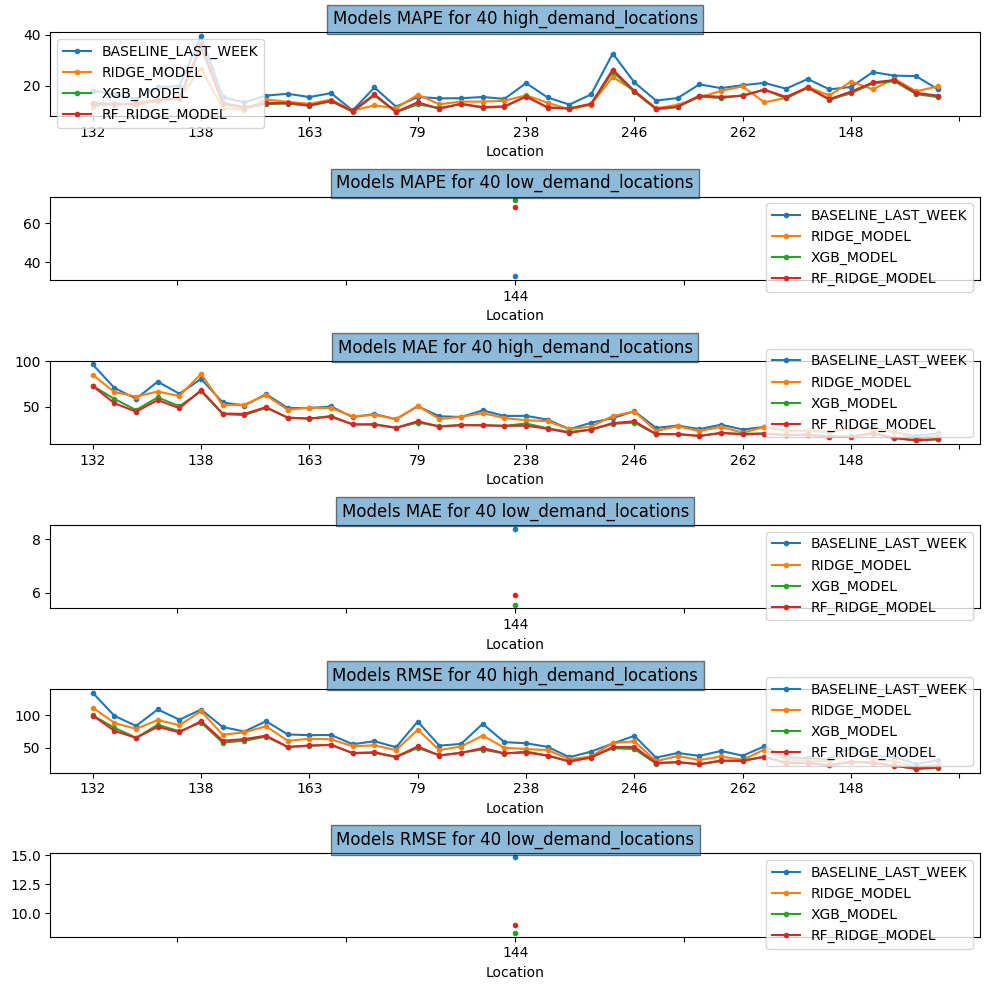

In [18]:
plot(predictions_mean_error_dict, 'Location')

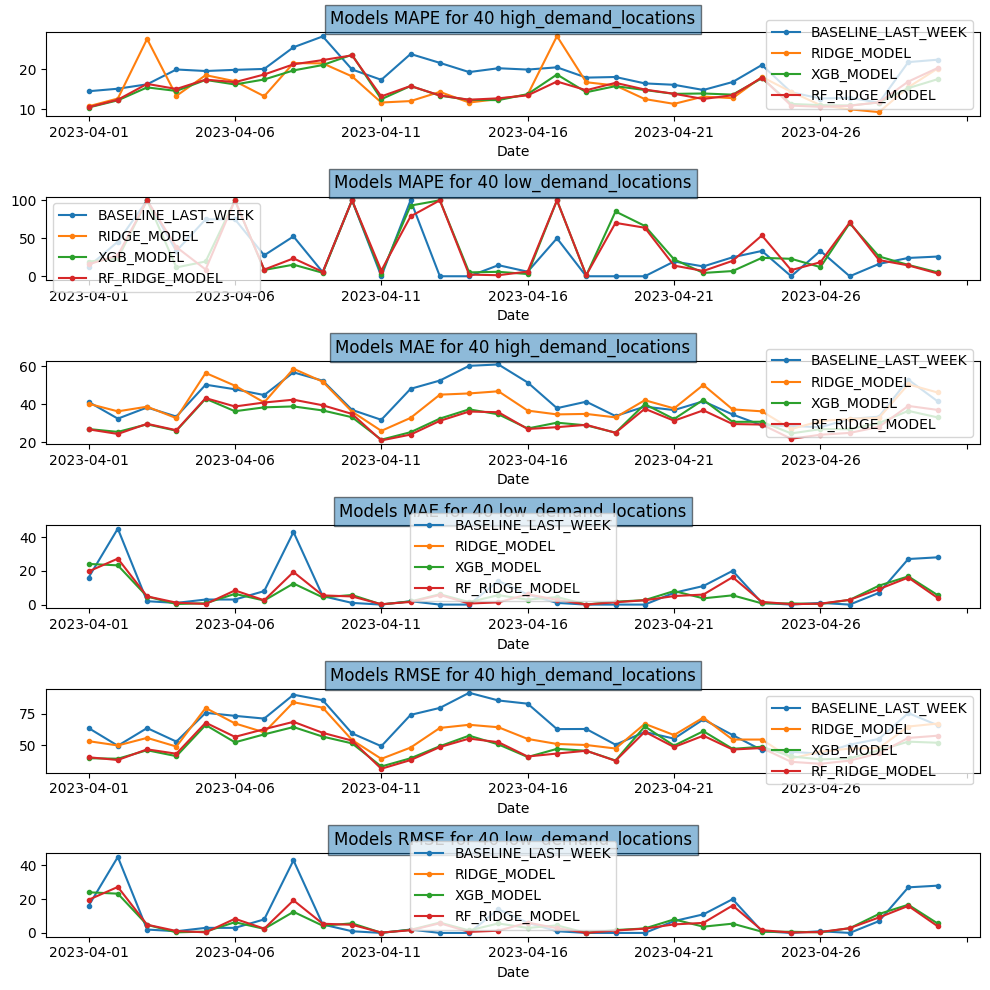

In [19]:
plot(predictions_mean_error_dict, 'Date')

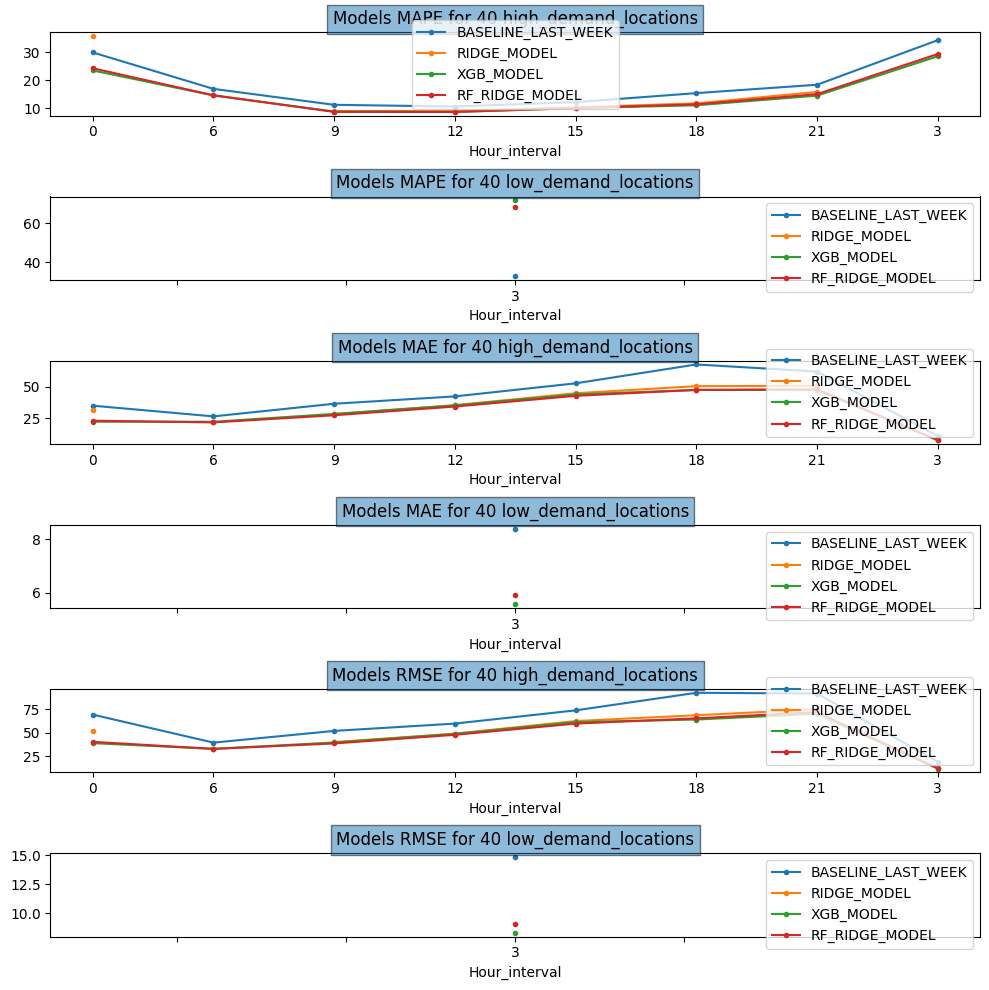

In [20]:
plot(predictions_mean_error_dict, 'Hour_interval')

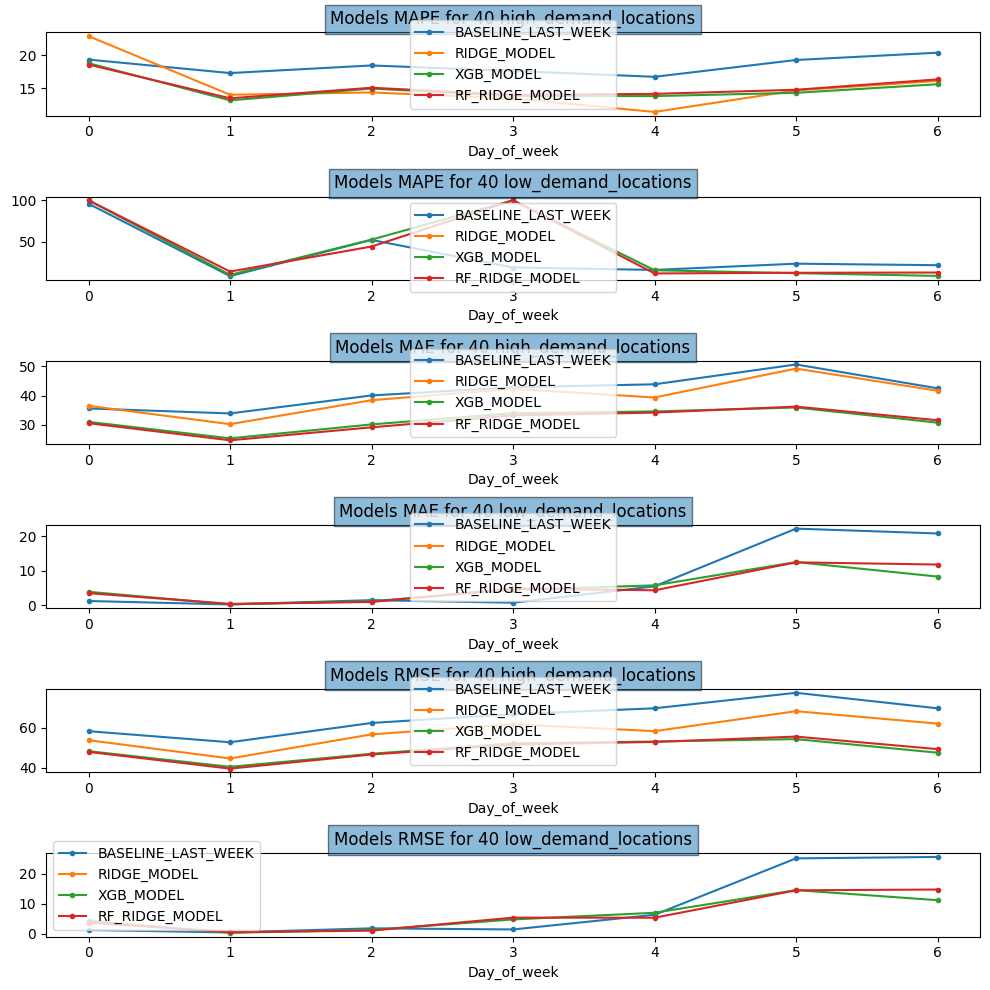

In [21]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [22]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location', 'Hour_interval']]
                categorized_df = error_df.merge(sorted_index, on=['Location','Hour_interval'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [23]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [24]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES, METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [25]:
df.style.format('{:.2f}')